In [15]:
# Standard library
from scipy.signal import find_peaks

# Third-party libraries
import gvar
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.decomposition import PCA

# Local modules
from fitting import (calculate_PCA, envelope, find_local_minima_maxima, get_nucl_range, 
                     get_range_dat, mask_uncertainities, PCA_fit, polynomial, preds_targets_zn, rms_val)
from nuclr.train import Trainer
from nuclr.data import semi_empirical_mass_formula

In [4]:
sns.set()
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [6]:
model_path = "spiral"
trainer = Trainer.from_path(model_path)

No sn, sp or binding data, skipping leave one out


In [8]:
model = trainer.models[0].cpu()
task_names = list(trainer.data.output_map.keys())

magic_numbers = [2, 8, 20, 28, 50, 82, 126]
data = trainer.data

In [9]:
proton_embs, neutron_embs, task_embs = model.emb
proton_embs = proton_embs.weight.detach().cpu().numpy()
neutron_embs = neutron_embs.weight.detach().cpu().numpy()
task_embs = task_embs.weight.detach().cpu().numpy()

In [10]:
znt = data.X[data.X[:, 2] == task_names.index("binding_semf")]
znt_np = znt.cpu().detach().numpy()
embs = model.embed_input(znt, model.emb)

In [11]:
znt

tensor([[  9,   9,   0],
        [  9,  10,   0],
        [  9,  11,   0],
        ...,
        [117, 176,   0],
        [117, 177,   0],
        [118, 176,   0]])

In [12]:
pca = PCA(n_components=5)
embs_pca = pca.fit_transform(embs.detach().cpu().numpy())
print("PCA:", pca.explained_variance_ratio_, "\n")

PCA: [0.43621793 0.05249805 0.04981869 0.0392231  0.03871229] 



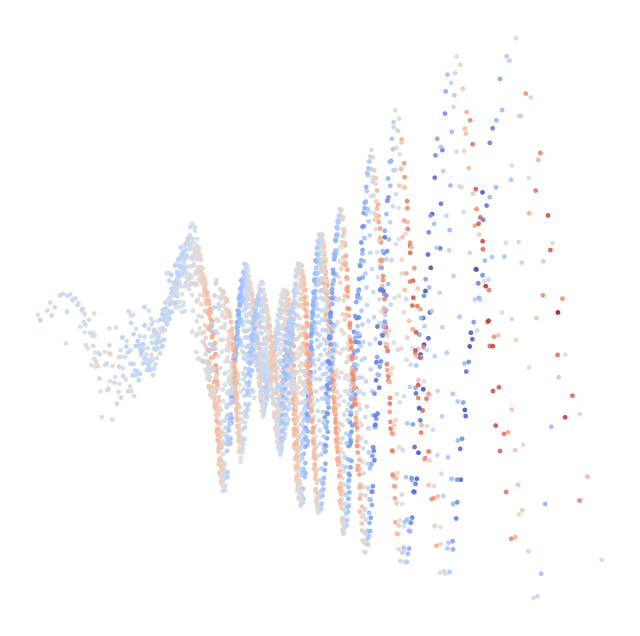

In [13]:
def scatter_2d_nuclei(x_axis_pc, y_axis_pc, color_pc):
    x = embs_pca[:, x_axis_pc]
    y = embs_pca[:, y_axis_pc]
    colors = embs_pca[:, color_pc]
    colors = (colors-min(colors))/(max(colors)-min(colors))
    colors = plt.cm.coolwarm(colors)

    fig, ax = plt.subplots(figsize=(8, 8))
    for idx, coords in enumerate(zip(x, y)):
        zn = znt[idx, :2].cpu().numpy()
        #plt.text(coords[0], coords[1], f"{zn[0]}-{zn[1]}", fontsize=8, ha="center", va="center", color=colors[idx], alpha=0.5)
    plt.scatter(x, y, c=colors, alpha=0.8, s=6)

    plt.xlabel(f"PC{x_axis_pc+1}")
    plt.ylabel(f"PC{y_axis_pc+1}")
    plt.axis("off")
    plt.show()
    
for i in range(1):
    for j in range(i+1, 2):
        scatter_2d_nuclei(i, j, j+1)

## Plot task prediction vs PCA component keeping Z fixed.

Next:
- Color even and odd N.

---

In [14]:
def plot_task_vs_pca(task_name, Z_number, embs_pca, pca_comp_x_axis, model, task_names, znt):
    """
    Plot a specific task against a principal component, while keeping the number of protons (Z) fixed and varying the number of neutrons (N).

    Parameters:
    - task_name (str): The name of the task to plot.
    - Z_number (int): The atomic number (number of protons) to keep fixed.
    - embs_pca (numpy.ndarray): The PCA-transformed embeddings.
    - pca_comp_x_axis (int): The index of the PCA component to use for the x-axis.
    - model
    - task_names (list): List of all task names.
    - znt (torch.Tensor) z,n and task concatenaded
    """
    # Find index of the task in the list of all tasks
    task_idx = task_names.index(task_name)
    
    # Mask to filter out data points for the specified atomic number (Z)
    z_mask = znt[:, task_idx] == Z_number
    inputs = znt[z_mask]

    # Get predictions from the model
    preds = model(inputs)
    preds = preds[:, task_idx].cpu().detach()

    # Extract PCA component values corresponding to the masked data points
    x = embs_pca[z_mask, pca_comp_x_axis]

    # Plotting
    sns.scatterplot(x=x, y=embs_pca[z_mask, pca_comp_x_axis+1], marker='o')
    plt.xlabel(f"PC{pca_comp_x_axis}")
    plt.ylabel(f"{task_name}")
    plt.title(f"{task_name} for Z={Z_number}")
    plt.show()

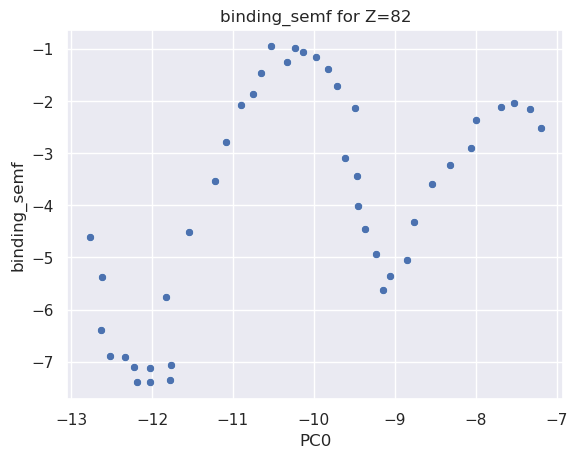

In [141]:
plot_task_vs_pca("binding_semf", Z_number=82, embs_pca=embs_pca, pca_comp_x_axis=0, model=model, task_names=task_names, znt=znt)

## Plot RMS of reconstructed embeddings vs PCA number of components.


Next:
- Push a cleaner version.
- Start creating a small function that takes a fitting to a PCA, then evaluates the function, then creates an embedding reconstruction with these evaluations and then reconstruct 

In [24]:
def sweep_pca_components(embs, true_data, max_components, task_name, task_names, targets, X, semf):
    """Generate a list of RMS errors for different number of PCA components."""
    
    rms_list = []
    component_list = list(range(2, max_components + 1))  # From 2 to max_components

    for n in component_list:
        pca = PCA(n_components=n)
        embs_pca = pca.fit_transform(embs.detach().cpu().numpy())
        print(f"Number of Components: {n}, Explained Variance: {pca.explained_variance_ratio_.sum()}\n")
        
        recons_embs = pca.inverse_transform(embs_pca)

        # Convert NumPy array to PyTorch tensor
        recons_embs_torch = torch.from_numpy(recons_embs).float().to(embs.device)

        # Forward pass
        # Find index of the task in the list of all tasks
        task_idx = task_names.index(task_name)
        tasks = znt[:, 2].cpu().numpy()
        scatter = tasks == task_idx # get only rows relevant to task

        preds_before = torch.sigmoid(model.readout(model.nonlinear(recons_embs_torch)))
        preds_before = preds_before.cpu().detach().numpy()
        preds_before = data.regression_transformer.inverse_transform(preds_before)[scatter, task_idx]

        preds_reconstructed = preds_before + semf

        mask_unc = mask_uncertainities(8, task_name)
        rms_error = rms_val(X, targets, preds_reconstructed, task_name, mask_unc=mask_unc)
        
        rms_list.append(rms_error)

    # Plotting the RMS errors
    plt.figure()
    plt.plot(component_list, rms_list, marker='o')
    plt.xlabel("Number of PCA Components")
    plt.ylabel("RMS Error")
    plt.title("RMS Error vs Number of PCA Components")
    plt.show()

    return rms_list

In [25]:
task_name = "binding_semf"
semf = semi_empirical_mass_formula(znt[:, 0], znt[:, 1]).cpu().numpy()
X, targets, preds = preds_targets_zn(model, data, task_name, train=True, val=True)

Number of Components: 2, Explained Variance: 0.4887159764766693

Number of Components: 3, Explained Variance: 0.5385345816612244

Number of Components: 4, Explained Variance: 0.577757716178894

Number of Components: 5, Explained Variance: 0.6164700984954834

Number of Components: 6, Explained Variance: 0.6489895582199097

Number of Components: 7, Explained Variance: 0.6782318353652954

Number of Components: 8, Explained Variance: 0.7036283612251282

Number of Components: 9, Explained Variance: 0.7185128927230835

Number of Components: 10, Explained Variance: 0.7321750521659851

Number of Components: 11, Explained Variance: 0.7448393702507019

Number of Components: 12, Explained Variance: 0.7568930983543396

Number of Components: 13, Explained Variance: 0.7679933309555054

Number of Components: 14, Explained Variance: 0.7778732180595398

Number of Components: 15, Explained Variance: 0.7871423959732056

Number of Components: 16, Explained Variance: 0.7960813045501709

Number of Component

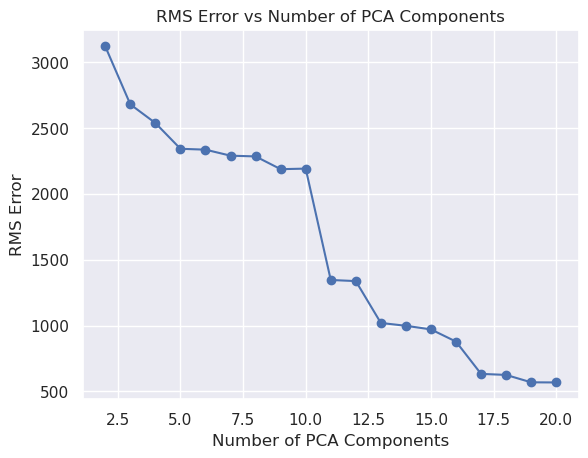

In [28]:
rms_results = sweep_pca_components(embs, targets, max_components=20, task_name=task_name, task_names=task_names, targets=targets, X=X, semf=semf)

In [23]:
rms_results

[1215390.6334099746,
 1215094.8820722853,
 1215168.0779438538,
 1215508.9487097077,
 1215477.7598895018,
 1215571.02052634,
 1215554.3802910387,
 1215394.661188654,
 1215383.714987308]